Caching


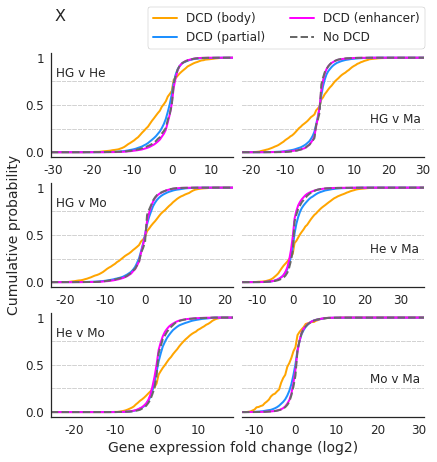

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot CDF of genes overlapping
# with HSPs in different ways
# (full, partial, enhancer etc.)

### THIS FILE IS JUST NEEDED TO PREPARE
### THE CORRECT CACHE DATA FOR OTHER PLOTS

date = '20180921'

run_hsp_deg_recovery = True

save_figures = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'isect_gene_hsp')


base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
genetrail_out = os.path.join(fhgfs_base, 'statediff/genetrail/input_lists')
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def extract_gene_table_header(fpath):
    """
    """
    hsp_header = 'chrom chromStart chromEnd name nat_score segment_expect segment_pv nat_score_lnorm group1 group2'.split()
    hsp_header = ['hsp_' + h for h in hsp_header]
    hsp_header += ['overlap']
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
        hd = ['gene_' + h for h in hd]
    joint_header = hd + hsp_header
    return joint_header


def extract_enh_table_header(fpath):
    """
    """
    enh_header = 'regtype chrom chromStart chromEnd name score strand symbol'.split()
    enh_header = ['enh_' + h for h in enh_header]
    enh_header = ['regtype'] + enh_header + ['overlap']
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
        hd = ['hsp_' + h in hd]
    joint_header = hd + enh_header
    return joint_header


def read_gene_overlap_table(fpath, header=None):
    """
    """
    if header is None:
        header = extract_gene_table_header(fpath)
    df = pd.read_csv(fpath, skiprows=1, header=None,
                     names=header, delimiter='\t')
    
    df = df[['gene_name', 'gene_start', 'gene_end', 'gene_log2fc', 'overlap']]
    ovl = df.groupby(['gene_name'], as_index=False)['overlap'].sum()
    df.drop(['overlap'], axis=1, inplace=True)
    df.drop_duplicates(['gene_name'], inplace=True)
    df = df.merge(ovl, on='gene_name', how='outer')
    df['gene_length'] = df['gene_end'] - df['gene_start']
    
    miss = df.loc[df['overlap'] == 0, :].copy()
    miss['pct_cov'] = 0
    
    ovl = df.loc[df['overlap'] > 0, :].copy()
    ovl['pct_cov'] = (ovl['overlap'] / ovl['gene_length']).round(5)
        
    df = pd.concat([miss, ovl], axis=0, ignore_index=False, sort=False)
    
    return df, header


def read_enh_overlap_table(fpath):
    """
    """
    hit_genes = set()
    regtype_idx = 10
    gene_name_idx = 17
    with open(fpath, 'r') as table:
        _ = table.readline()
        for line in table:
            if line.strip():
                columns = line.strip().split('\t')
                if columns[regtype_idx] == 'GENEHANCER':
                    ensid = columns[gene_name_idx]
                    assert ensid.startswith('ENSG'), 'Unrecognized identifier: {}'.format(line.strip())
                    hit_genes.add(ensid)
    return hit_genes


def get_partner_file(fpath, which):
    """
    """
    if which == 'promoter':
        ppath = os.path.dirname(fpath).replace('/isect_gene_hsp', '/isect_prom_hsp')
        pname = os.path.basename(fpath).replace('gene_', 'prom_')
        partner = os.path.join(ppath, pname)
        assert os.path.isfile(partner), 'Created invalid path to partner file: {}'.format(partner)
    elif which == 'enhancer':
        ppath = os.path.dirname(fpath).replace('/isect_gene_hsp', '/isect_hsp_any')
        pname = os.path.basename(fpath).replace('gene_ovl_hsp', 'hsp_ovl_reg')
        partner = os.path.join(ppath, pname)
        assert os.path.isfile(partner), 'Created invalid path to partner file: {}'.format(partner)
    else:
        raise ValueError('Unexpected partner requested: {}'.format(which))
    return partner


def cache_deg_overlaps(cache_file, ext_cache, gene_hsp_ovl):
    """
    """
    with open(ext_cache, 'rb') as cache:
        gene_hits = pck.load(cache)
    
    table_header = None
    for tsv in sorted(os.listdir(gene_hsp_ovl)):
        if not tsv.endswith('.tsv'):
            continue
        tsv_path = os.path.join(gene_hsp_ovl, tsv)
        parts = tsv.split('.')[0].split('_')
        seg, score = parts[3], parts[-1]
        comp = parts[4] + '_vs_' + parts[6]
        # gene_ovl_hsp_cmm18_HG_vs_He_ordem.tsv
        genes, table_header = read_gene_overlap_table(tsv_path, table_header)
        assert genes.shape[0] == 20091, 'Missing genes'
        genes['hit_group'] = 4
        genes['body_hit'] = 0
        genes['prom_hit'] = 0
        genes['enh_hit'] = 0
        genes.loc[genes['pct_cov'] > 0, 'body_hit'] = 1
                        
        prom_file = get_partner_file(tsv_path, 'promoter')
        prom, table_header = read_gene_overlap_table(prom_file, table_header)
        prom_hit = prom.loc[prom['pct_cov'] > 0, 'gene_name']
        genes.loc[genes['gene_name'].isin(prom_hit), 'prom_hit'] = 1
                
        enh_file = get_partner_file(tsv_path, 'enhancer')
        enh_hits = read_enh_overlap_table(enh_file)
        genes.loc[genes['gene_name'].isin(enh_hits), 'enh_hit'] = 1
        
        genes.loc[genes['pct_cov'] > 0.5, 'hit_group'] = 1
                
        select_a = np.logical_and(genes['pct_cov'] <= 0.5, genes['body_hit'] == 1)
        select_b = np.logical_and(genes['body_hit'] == 0, genes['prom_hit'] == 1)
        selector = np.logical_or(select_a, select_b)
        genes.loc[selector, 'hit_group'] = 2
        
        select_a = np.logical_and(genes['body_hit'] == 0, genes['prom_hit'] == 0)
        selector = np.logical_and(select_a, genes['enh_hit'] == 1)
        genes.loc[selector, 'hit_group'] = 3
                                
        store_path = os.path.join(seg, score, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(store_path, genes, format='fixed')
    return cache_file


def plot_hsp_gene_cdf(dataset, fkey, zoomed):
    """
    """
    comparisons = sorted(dataset['comparison'].unique())
    assert len(comparisons) == 6, '.....'
        
    ncols = 2
    nrows = 3
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
    stepsize = 0.5
    plt.subplots_adjust(wspace=0.05, hspace=0.25)
    
    group_labels = {1: 'DCD (body)',
                    2: 'DCD (partial)',
                    3: 'DCD (enhancer)',
                    4: 'No DCD'}
    
    comp_idx = 0
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]
            
            comp = comparisons[comp_idx]
            comp_idx += 1
            
            sub = dataset.loc[dataset['comparison'] == comp, :].copy()
            sub.reset_index(drop=True, inplace=True)
            
            bins, bin_nums = generate_bins(sub, stepsize)
            
            if zoomed:
                x_ticks = [-2, 0, 2]
                ax.set_xticks(x_ticks)
                ax.set_xlim(-2.25, 2.25)
            else:
                neg_ticks = np.arange(0, bins.min(), -10)[::-1]
                pos_ticks = np.arange(0, bins.max(), 10)

                x_ticks = np.concatenate([neg_ticks, pos_ticks[1:]])
                x_ticks = x_ticks.astype(np.int8)
                
                ax.set_xlim(bins.min(), bins.max())
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(map(str, x_ticks), fontsize=12)
    
            y_ticks = [0., 0.5, 1]
            ax.set_ylim(-0.05, 1.05)
            
            plot_label = ' v '.join(comp.split('_vs_'))
            if plot_label.endswith('Ma'):
                ax.text(0.7, 0.33, plot_label, fontsize=12, transform=ax.transAxes)
            else:
                ax.text(0.025, 0.77, plot_label, fontsize=12, transform=ax.transAxes)
            
            for g, c in zip([1,2,3,4], ['orange', 'dodgerblue',
                                        'magenta', 'dimgrey']):
                group_data = sub.loc[sub['hit_group'] == g, 'gene_log2fc']
                hist, bin_edges = np.histogram(group_data,
                                               bins=bins,
                                               density=True)
                hist = np.concatenate([[0], hist])
                assert np.isclose(hist.sum() * stepsize, 1., atol=1e-6), 'CDF not 1'
                
                if g == 4:
                    linestyle = 'dashed'
                else:
                    linestyle = 'solid'
                ax.plot(bins, np.cumsum(hist) * stepsize,
                        lw=2, ls=linestyle, c=c, label=group_labels[g])
                            
                ax.axhline(0.75, 0, 1, c='lightgrey',
                           ls='dashed', zorder=0, lw=1)
                ax.axhline(0.5, 0, 1, c='lightgrey',
                           ls='dashed', zorder=0, lw=1)
                ax.axhline(0.25, 0, 1, c='lightgrey',
                           ls='dashed', zorder=0, lw=1)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if col == 1:
                ax.spines['left'].set_visible(False)
                        
            if col == 0:
                ax.set_yticks(y_ticks)
                ax.set_yticklabels(map(str, y_ticks), fontsize=12)
            else:
                ax.set_yticks([])
                
            if col == 0 and row == 0:
                leg = ax.legend(loc='upper left', bbox_to_anchor=[0.5, 1.5],
                                fontsize=12, ncol=2, edgecolor='grey', frameon=True)
                tt = ax.set_title(fkey, fontsize=16)
                tt.set_position((0.05, 1.25))
            if row == 1 and col == 0:
                ax.set_ylabel('Cumulative probability', fontsize=14)
            if row == 2 and col == 0:
                xl = ax.set_xlabel('Gene expression fold change (log2)', fontsize=14)
                xl.set_position((1, 0))
            
    return fig, [tt, leg]


def generate_bins(dataset, stepsize):
    """
    """
    fc_min = dataset['gene_log2fc'].min()
    assert fc_min < 0, 'That is unexpected...'
    fc_lower = (fc_min // stepsize) * stepsize - stepsize
    fc_max = dataset['gene_log2fc'].max()
    fc_upper = (fc_max // stepsize) * stepsize + stepsize
    bins = np.arange(fc_lower, fc_upper + 0.1, stepsize)
    bin_num = [i for i, b in enumerate(bins, start=1)]
    return bins, bin_num
    


def plot_hsp_deg_recovery():
    # load HSP hits from other cache file
    # to avoid redundant work
    external_cache = os.path.join(cache_dir, '20180921_plot_gene_recov_hsp.pck')
    assert os.path.isfile(external_cache), 'External cache file does not exist: {}'.format(external_cache)
    
    cache_file = os.path.join(cache_dir, '{}_plot_hsp_deg_cdf.h5'.format(date))
    if not os.path.isfile(cache_file) or os.stat(cache_file).st_size < 1e6:
        print('Caching')
        _ = cache_deg_overlaps(cache_file, external_cache, isect_root)
    
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for score in scorings:
                if score != 'penem':
                    continue
                load_keys = [k for k in cached_keys if seg in k and score in k]
                plot_data = []
                for k in load_keys:
                    if 'Liver_vs_Blood' in k:
                        continue
                    data = hdf[k]
                    data['comparison'] = k.split('/')[-1]
                    plot_data.append(data)
                plot_data = pd.concat(plot_data, ignore_index=False, axis=0)
                if seg == 'cmm18':
                    fk = 'X'
                    out_folder = fig_main
                elif seg == 'ecs18':
                    fk = 'SX'
                    out_folder = fig_supp
                else:
                    raise
                fig, exart = plot_hsp_gene_cdf(plot_data, fk, False)
                
                if save_figures:
                    outname = 'fig_{}_hsp_gene_cdf_{}_{}'.format(fk, seg, score)

                    out_pdf = os.path.join(out_folder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

                    out_png = os.path.join(out_folder, outname + '.png')
                    fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return



if run_hsp_deg_recovery:
    plot_hsp_deg_recovery()